# SSM Model Description

The Synaptic Source Mixing (SSM) Model of interareal coherence between field potentials is a model developed by Martin Vinck and collaborators (*A Mechanism for Inter-Areal Coherence through Communication based on Connectivity and Oscillatory Power*, 2021). As opposed to the Communication-Through-Coherence (CTC) hypothesis popularized by Pascal Fries in his 2005 and 2015 papers, the SSM model operates off on the assumption that coherence is not the cause of, but a signature of communication. Through various data and model based simulations using the SSM model, Vinck displays that communication is dependent on signal strength (power) and connection weights between communicating regions. The model does not assume coupling between regions or phase locking between sending and receiving regions.  


# Package Dependencies

In [77]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy import signal
from colorednoise import powerlaw_psd_gaussian
from scipy.fft import fft, fftfreq, ifft

# Model Metrics
The following are definitions (mathematical where possible) of terms, variables, and metrics used in the SSM model. 


**Volume Conduction**
Volume conduction refers to how electric currents are conducted throughout tissues, the brain or another volume that conducts electricity. In the brain, axons conduct moving dipoles, conducting currents throughout the volume. Underlies EEG. 


**Coupling Weight**
The strength of the synaptic connection between two neural regions or neurons. By convention, the strongest connection is typically assigned 1 and the weakest (no connection) 0. 


**Sender Oscillation Strength (SOS)**
The ratio between signal oscillation power to the background $1/f^n$ broadband noise. For a sending region with power spectral density $S_{11}(t)$ for its oscillatory signal $s_1(t)$ and power spectral density $H(f)$ for the power spectral density of its background broadband frequency, we have SOS,

$\alpha(f) = \frac{S_{11}(f)}{H(f)}.$


**Pairwise Phase Locking (PPL)**
How consistent phases of oscillations between regions are. 


**Pairwise Phase Consistency (PPC)**
This is a means of measuring PPL. Describes how similar two measurements/signals are in phase. Computes the cosine of the absolute angular distance (vector dot product) for each phase of two signals. 


**Weighted Phase Lag Index (WPLI)**
How much phase angle differences between two time series are distributed on the imaginary axis when viewed in the complex plane. It is an alternative metric to coherence.

The Phase Lag Index (PLI) is the magnitude of the average sum of the signs of the imaginary part of the complex cross spectral density $S_{xy}$ of two real signals $x(t)$ and $y(t)$ on a given trial or at a given timepoint. 

$PLI = |\frac{\sum_{t=1}^n sgn(imag(S_{xy,t}))}{n} | $

The WLPI adjusts this metric by scaling contributions of angle differences by their distance to the real axis. It addesses confounds caused by volume conduction. 

$WLPI = |\frac{ |\sum_{t=1}^n sgn(imag(S_{xy,t}))| sgn(imag(S_{xy,t})) }{\sum_{t=1}^n imag(S_{xy,t}) } |$


**Granger Causality (Vinck)** 
Granger causality refers to the hypothesis that if one signal “granger causes” another, then past values of the causal signal should contain information that helps predict past values of the effect signal better than information contained in past values of the effect signal. It is based on linear regression modelling of stochastic time series data. Extensions to nonlinear modeling and the spectral domain (useful for neurophysiological signals) do exist.  


**Squared Coherence**
For discrete time series $x(t)$ and $y(t)$, with power spectral densities $P_{xx}$ and $P_{yy}$ respectively and cross spectral density $P_{xy}$, the magnitude squared coherence estimate is given by:

$C_{xy} = \frac{|P_{xy}|^2}{P_{xx} P_{yy}}$


*Squared Coherence (SCIPY):*
Estimated using Welch's method, an approach for spectral density estimation. Reduces noise in exchange for reducing frequency resolution


*Squared Coherence (Vinck):*
Introduces a proportional relationship between coherence and three other factors. 

1. Interareal Connectivity: Measured with coupline weight $w$, influed by the number of active synapses between the sending and receiving areas and their level of activity.
2. Sender and receiver signal power (shape). Measured by SOS $\alpha(f)$.
3. Source-projection coherence $C^2_{source_proj}(f)$.

These dependencies are captured in the relation:

$C^2(f) \approx w^2(\alpha(f) + 1)C^2_{source, proj}(f)$.


**Source Projection Coherence (Vinck):**
The coherence between the LFP signal in teh sender and the received signal. Projected signal may not be a fully coherent copy of the sent signal since not all neurons that the signal is sent through are always projected to the receiving area. 

Source-Projection Coherence depends on two factors.

1. Number of projecting neurons $N_p$ between the sending and receiving populations. The more projecting neurons, the more coherent the signal.
2. Coherence between activity of individual spiking neurons and the sender LFP, $\phi^2$.

These relations are captured by: 
$C^2_{source, proj} \approx N_p \phi^2(f)$.

## Basic Model Description

We assume that a received signal will be correlated with the sent signal. The received signal will be a mixture of local noise or inputs, and those received by the sending region. 

### SSM Model without Source-Projection Coherence

This model describes the simpler, less biophysically realistic case of unidirectional communication without source projection coherence. This model assumes that the received signal is fully coherent with the sent signal. Let $z_1(t)$ and $z_2(t)$ be the measure signals of the sending and receiving populations, respectively. 
The sender signal is modelled as follows:

$z_1(t) = s_1(t) + \eta_1(t)$ 

where $s_1$ is an oscillatory process and $\eta_1$ is a broad-band process such as pink noise. 

According to the SSM, oscillatory processes are modelled as AR(2) processes. The AR(2) model is $x_t = a_1 x_{t - 2} + a_2 x_{t-1} + \eta_t$ with roots lying in the unit circle. $\eta_t$ is typically modelled as a zero mean white noise process but is modelled here as a random gaussian process centered at 0. These processes are typically fit to experimental data, but we we use the arbitrary AR(2) process:

$x_t = 1.2 x_{t - 2} - 0.94 x_{t-1} + \eta_t $

Broad-band processes are $ 1 / f^{2/3} $ pink-noise processes. Rather than follow the process outlined in Vinck 2021, the powerlaw_psd_gaussian process is used to generate a color noise broad-band signal. 

The receiver signal is dependent on the sender signal, modelled without an oscillatory process of its own.

$z_2(t + \tau) = \eta_2(t + \tau) + w z_1(t)$. 

The receiver signal is a linear combination of its own noise process and the connection weighted received signal $z_1(t)$. It is assumed that the power spectral densities of the noise processes for the sending and receiving areas are identical, so the same noise process is used for both regions. For modeling purposes (and comparison of coherence when the receiving region receives the signal rather than for both regions at the same timepoint), we disregard the time delay in the original equation, and treat the receiving region as receiving the signal from the sending region immediately after it is sent. This will make the analyses to follow easier to make. 

In [82]:
random_state = np.random.RandomState(123)

# Sender signal parameters 
SOS = 10              # Sender Oscillation Strength
W = 0.1               # Connection weight between sending and receiving regions
TSTOP =  1            # Length of timeseries
SAMPLING_RATE = 200   # Sampling rate (samples/second)

def generate_harmonic_AR2_process(
        n_points: int,  
        random_state: np.random.RandomState, 
        burn_in: int):

    out = np.zeros(burn_in + 110)

    # Starting values for the signal
    out[0] = 20
    out[1] = 100

    # Populating the signal based on an arbitrary AR(2) process.
    for i in range(2, len(out)):
        # NOTE: Altering the random gaussian process here greatly changes the results. 
        out[i] = 0.6 * out[i - 1] - 0.94 * out[i - 2] + random_state.normal(0, 0.1)

    out = out[burn_in:]
    return signal.resample(out, n_points)

def generate_noise_process(n_points: int, random_state: np.random.RandomState, f_exp: float = 2/3):
    s_noise = powerlaw_psd_gaussian(f_exp, size = n_points, random_state = random_state) * 0.1
    return s_noise


def generate_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state):
    # Generate osc. process and noise of the sender
    s1 = generate_harmonic_AR2_process(int(tstop * sampling_rate), random_state, 20)
    n1 = generate_noise_process(int(tstop * sampling_rate), random_state)

    # FFT the sender's components and scale freq_SOS according to SOS
    n1_fft = fft(n1)
    freqs = fftfreq(int(tstop * sampling_rate), 1 / sampling_rate)

    alpha_f, s1_psd = signal.welch(s1, fs = sampling_rate)
    alpha_f, n1_psd = signal.welch(n1, fs = sampling_rate)
    alpha = s1_psd / n1_psd

    current_SOS = alpha[np.argmin(np.abs(alpha_f - freq_SOS))]
    multiplier = SOS / current_SOS
    
    n1_fft[np.argmin(np.abs(freqs - freq_SOS))] = n1_fft[np.argmin(np.abs(freqs - freq_SOS))] * np.sqrt(multiplier)
    n1_adjusted = ifft(n1_fft).real

    # Total sender
    z1 = s1 + n1_adjusted

    # Total receiver ( + scale its noise)
    n2 = generate_noise_process(int(tstop * sampling_rate), random_state)
    z2 = n2 + w * z1

    return z1, z2, n1, n1_adjusted, alpha, alpha_f


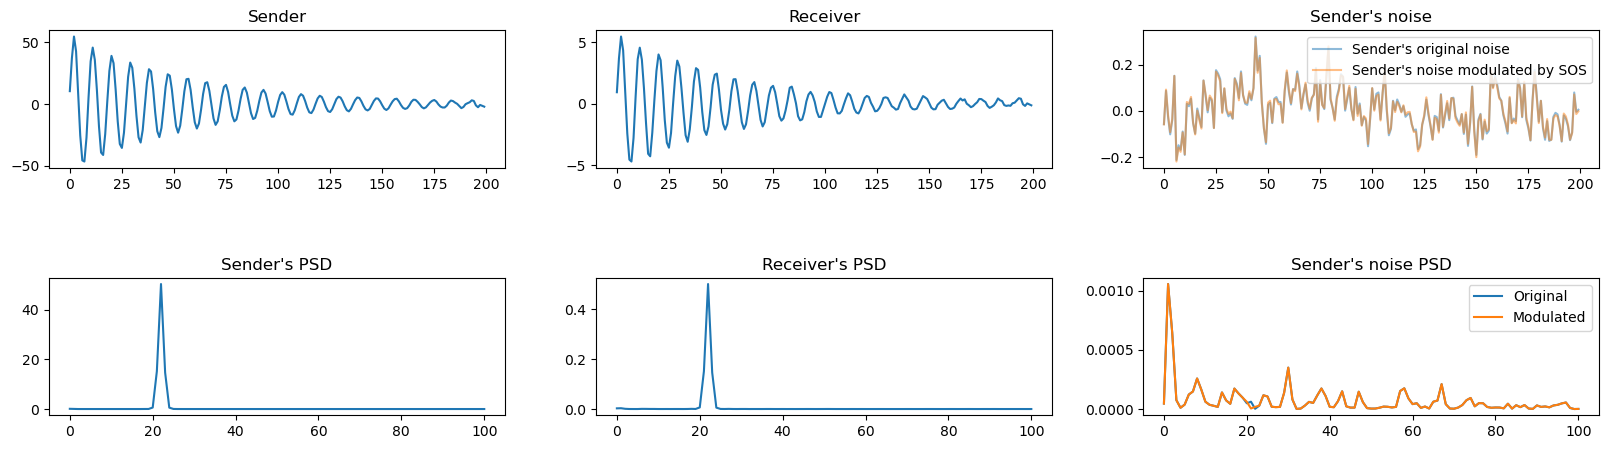

In [83]:
# Signal Check
fig, ax = plt.subplots(2, 3, figsize = (20, 5))

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state)

ax.flatten()[0].plot(z1)
ax.flatten()[0].set_title("Sender")

ax.flatten()[1].plot(z2)
ax.flatten()[1].set_title("Receiver")

ax.flatten()[2].plot(n1, alpha = 0.5, label = "Sender's original noise")
ax.flatten()[2].plot(n1_adjusted, alpha = 0.5, label = "Sender's noise modulated by SOS")
ax.flatten()[2].legend()
ax.flatten()[2].set_title("Sender's noise")

f, psd = signal.welch(z1, fs = SAMPLING_RATE)
ax.flatten()[3].plot(f, psd)
ax.flatten()[3].set_title("Sender's PSD")

f, psd = signal.welch(z2, fs = SAMPLING_RATE)
ax.flatten()[4].plot(f, psd)
ax.flatten()[4].set_title("Receiver's PSD")

f, psd = signal.welch(n1, fs = SAMPLING_RATE)
ax.flatten()[5].plot(f, psd, label = "Original")
f, psd = signal.welch(n1_adjusted, fs = SAMPLING_RATE)
ax.flatten()[5].plot(f, psd, label = "Modulated")
ax.flatten()[5].set_title("Sender's noise PSD")
ax.flatten()[5].legend()

fig.subplots_adjust(hspace = 0.8)

## Vinck 2021 Figure 2 Replication

Here, we will replicate the results of Figure 2 A, C-E in Vinck 2021, to demonstrate the relationships underlying the SSM model, namely that inter-areal coherence is predicted by connection weight and power (quantified by SOS) and communication can result without the use of coherence.

#### Figure 2A
This figure demonstrates the dependencies of the sender signal on power, squared coherence, Granger Causality, and the transfer function (no dependency), and the receiver signal on power. 

**Figure 2A(1): Power**

To model the dependencies of the sender signal on power, we can simply plot the sender PSD, as calculated above. We will plot the receiver PSD on the same plot for comparison purposes (though they are separated in Vinck 2021). 

In [85]:
def generate_sender_receiver_psd(tstop, sampling_rate, SOS, freq_SOS, w, random_state):
    z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state)
    s1 = z1 - n1_adjusted
    f, psd_s1 = signal.welch(s1, fs = sampling_rate)
    f, psd_n1 = signal.welch(n1_adjusted, fs = sampling_rate)
    # Total sender
    psd_z1 = psd_s1 + psd_n1
    # Total receiver
    psd_z2 = w**2 * psd_z1 + psd_n1
    return f, psd_z1, f, psd_z2

def generate_sender_receiver_scipy_psd(tstop, sampling_rate, SOS, freq_SOS, w, random_state):
    z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state)
    f_z1, psd_z1 = signal.welch(z1, fs=sampling_rate, nperseg=64)
    f_z2, psd_z2 = signal.welch(z2, fs=sampling_rate, nperseg=64)
    return f_z1, psd_z1, f_z2, psd_z2

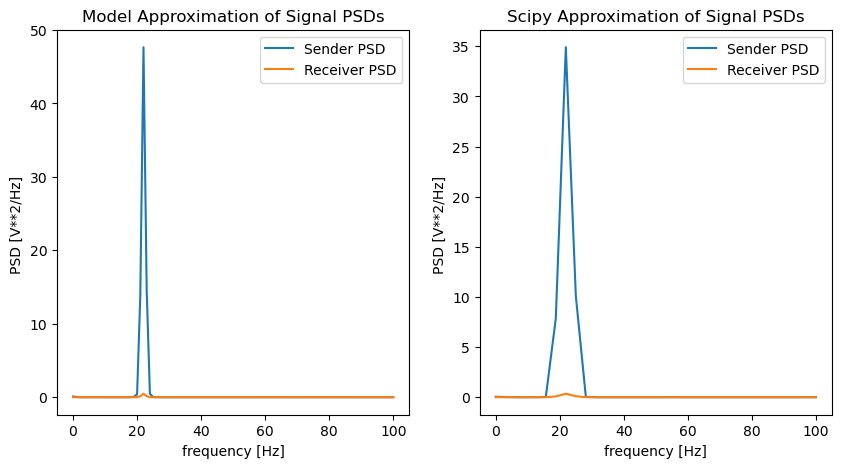

In [86]:

f_z1, psd_z1, f_z2, psd_z2 = generate_sender_receiver_psd(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(f_z1, psd_z1, label="Sender PSD")
axes[0].plot(f_z2, psd_z2, label="Receiver PSD")
axes[0].set_xlabel('frequency [Hz]')
axes[0].set_ylabel('PSD [V**2/Hz] ')
axes[0].set_title('Model Approximation of Signal PSDs')
axes[0].legend()

fscipy_z1, psdscipy_z1, fscipy_z2, psdscipy_z2 = generate_sender_receiver_scipy_psd(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state)
axes[1].plot(fscipy_z1, psdscipy_z1, label="Sender PSD")
axes[1].plot(fscipy_z2, psdscipy_z2, label="Receiver PSD")
axes[1].set_xlabel('frequency [Hz]')
axes[1].set_ylabel('PSD [V**2/Hz] ')
axes[1].set_title('Scipy Approximation of Signal PSDs')
axes[1].legend()

plt.show()

We expect to see a highly peaked sender signal at 20 Hz (in the beta frequency band) and a corresponding, but diminished received signal at 20 Hz. Since the power spectral densities of the noise components of the sender and receiver PSDs are assumed to be equal, the signals should only significantly differ in the beta band. 

**Figure 2A(2): Coherence**

Here, we focus on how coherence is calculated from the oscillatory and noise processes of the sent and received signals and the power spectral densities of the sending and receiving regions. 

First we compute the spectral densities of each signal. For the sending region with oscillatory process spectral density $S_{11}(f)$ and broad-band process spectral density $H(f)$ (Eq. 6):

$Z_{11} = S_{11}(f) + H(f)$.

For the receiving region with (the same) broad-band process spectral density $H(f)$ (Eq. 9):

$Z_{22} = H(f) = w^2 Z_{11}(f)$.

Now, the cross spectral density between the sending and receiving regions is given by (Eq. 6):

$Z_{12} = w Z_{11}(f)$.

The squared coherence between the sending and receiving regions  follows from the following relation (Eq. 7):

$C^2(f) = \frac{Z_{12}(f)^2}{Z_{11}(f) Z_{22}(f)}$

This relation is used throughout to calculate squared coherence from the power spectral densities of the sending and receiving signals. In the following code example, we assume that at $f_1 = 20 Hz$, $SOS(f_1) = 14$ and $w = 0.1$.

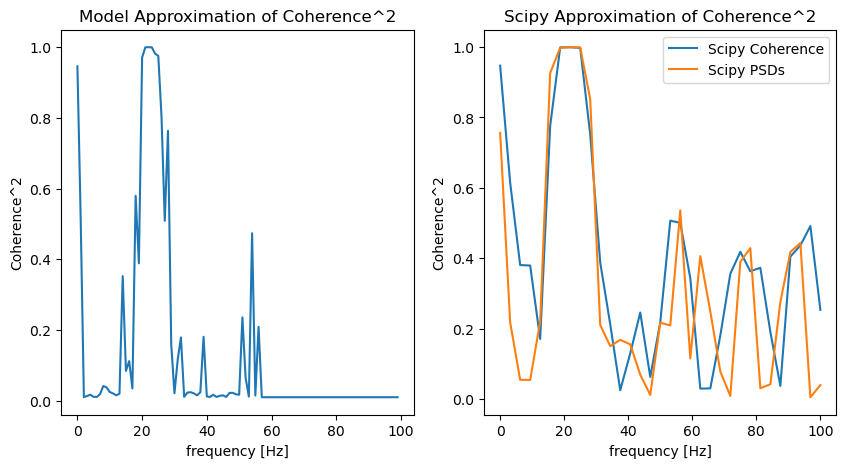

In [89]:
def get_coherence2(tstop, sampling_rate, SOS, freq_SOS, w, random_state):
    z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state)
    # Only using positive frequencies...
    end_index = np.where(freqs == np.max(freqs))[0][0]
    freqs = freqs[:end_index]
    alpha = alpha[:end_index]
    
    # Calculate coherence
    coh2 = ((w**2)*(1 + alpha))/(1 + w**2 * (1 + alpha))
    return freqs, coh2

def get_scipy_coherence2(tstop, sampling_rate, SOS, freq_SOS, w, random_state):
    z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state)
    
    # Calculate coherence
    f, Z11 = signal.welch(z1, fs=sampling_rate, nperseg=64)
    f, Z22 = signal.welch(z2, fs=sampling_rate, nperseg=64)
    f, Z12 = signal.csd(z1, z2, fs=sampling_rate, nperseg=64)

    coh2 = np.abs(Z12)**2 / (Z11 * Z22)
    return f, coh2

# Plot!
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
f, coh2 = get_coherence2(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
ax[0].plot(f, coh2)
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Coherence^2')
ax[0].set_title('Model Approximation of Coherence^2')

f_scipy_psds, coh2_scipy_psds = get_scipy_coherence2(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
f_scipy, coh2_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)
ax[1].plot(f_scipy, coh2_scipy, label="Scipy Coherence")
ax[1].plot(f_scipy_psds, coh2_scipy_psds, label="Scipy PSDs")
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Coherence^2')
ax[1].set_title('Scipy Approximation of Coherence^2')
ax[1].legend()
plt.show()

Fitting the SOS at a single frequency (as specified in the paper) results in a rather noisy display, but we see the anticipated beta peak in coherence. 

**Figure 2A(3): Granger Causality**

Using equation 16 in Vinck 2021, we can estimate granger causality using squared coherence. The Granger causality from the sending region to the receiving region is given by:

$G_{1 \rightarrow 2}(f) = - ln(1 - C^2(f))$.

We can't approximate this metric using python's scipy package. Plotting this result yields:

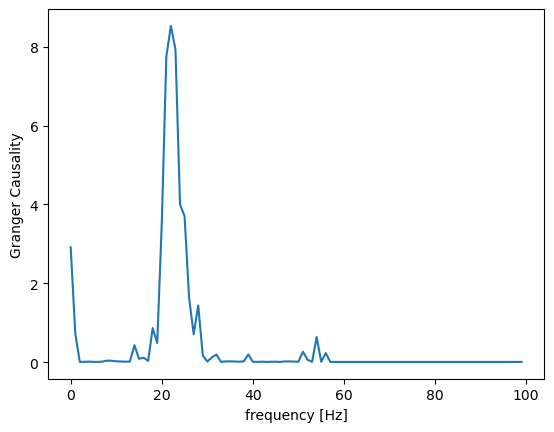

In [92]:
granger = - np.log(1 - coh2)

# Plot!
fig, ax = plt.subplots()
ax.plot(f, granger)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Granger Causality')
plt.show()

Notice that squared coherence is approximately equal to granger causality here. As shown, taking the first order Taylor expansion around $C(f) = 0$ yields:

$G_{1 \rightarrow 2}(f) \approx C^2(f)$.

**Figure 2A(4): Transfer Function**

The transfer function definition is assumed to be defined as in control theory. We can't approximate this metric using python's scipy package. Here, we see that inputs from all frequencies affect the receiving region in the same way. Here, we take the ratio between the power spectral densities of the oscillatory processes of the signals from the sender and receiver regions. 

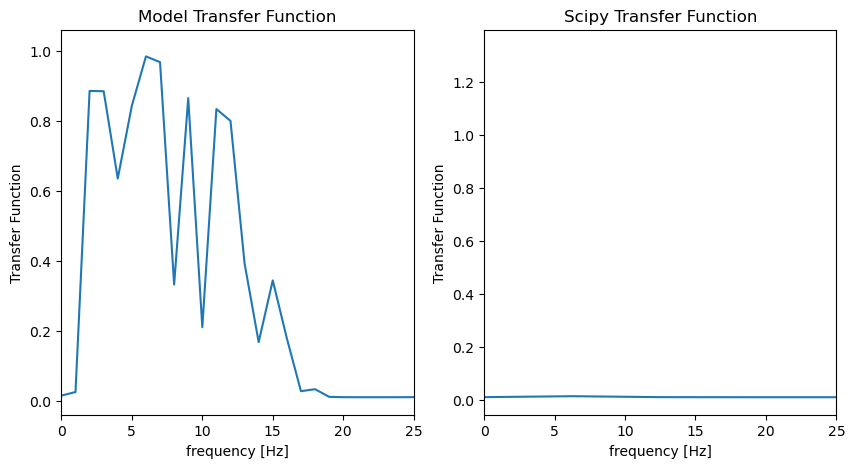

In [95]:
f_z1, psd_z1, f_z2, psd_z2 = generate_sender_receiver_psd(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
transfer = psd_z2 / (psd_z1)

f_z1_scipy, psd_z1_scipy, f_z2_scipy, psd_z2_scipy = generate_sender_receiver_scipy_psd(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)
f_scipy, psd_z1_scipy = signal.welch(z1, fs = SAMPLING_RATE, nperseg = 32)
f_scipy, psd_z2_scipy = signal.welch(z2, fs = SAMPLING_RATE, nperseg = 32)
transfer_scipy = psd_z2_scipy / (psd_z1_scipy)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(f_z1, transfer)
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Transfer Function')
ax[0].set_title('Model Transfer Function')
ax[0].set_xlim(0, 25)

ax[1].plot(f_scipy, transfer_scipy)
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Transfer Function')
ax[1].set_title('Scipy Transfer Function')
ax[1].set_xlim(0, 25)
plt.show()

#### Figure 2C 
This figure demonstrates the relationship between squared coherence and the coupling weight at various oscillation strengths. This graph takes advantage of a relationship given in equation 13 in the text:

$C^2(f) = \frac{w^2(1 + \alpha(f))}{1  + w^2(1 + \alpha(f)}$

We can replicate the figure by taking a list of logarithmically spaced weights between $10^{-2}$ and $10^1$, then calculating the coherence at various sender oscillation strengths, as shown below. 

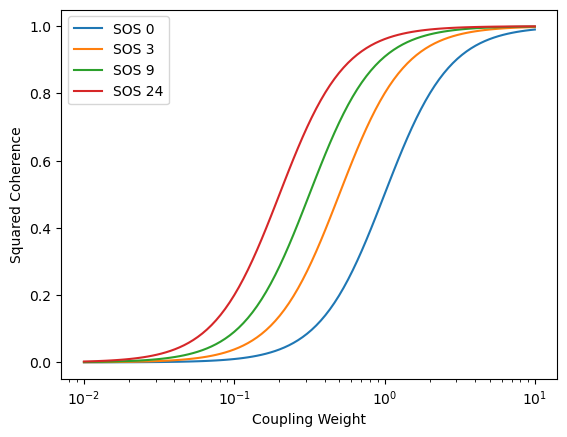

In [97]:
# Creating a list of logarithmically spaced weights
w = np.logspace(-2, 1, num=100)   
fig, ax = plt.subplots()

# Selecting SOS values according to the original plot.
for sos in [0, 3, 9, 24]:            
    # Calculating squared coherence based on the relation above.
    c2_sos = ((w**2) * (1 + sos)) / (1 + (1 + sos) * (w**2))
    ax.plot(w, c2_sos, label="SOS " + str(sos))

# Plotting results.
plt.xscale("log")
ax.set_xlabel('Coupling Weight')
ax.set_ylabel('Squared Coherence')
plt.legend()
plt.show()

#### Figure 2D
This figure consists of two plots that comparing squared coherence vs frequency for individually varied coupling weights and SOS, with the other variable held constant in either plot. This effectively displays that increased coupling weight or increased SOS results in a more coherent signal, which supports the dependence of coherence on these quantities.

These simulations are similar to those for coherence in Figure 2A, except in Figure D1, the connectivity weights are varied, taking on the values of $w_1 = 0.025$ and $w_2 = 0.035$ with $SOS = 10$ throughout. 

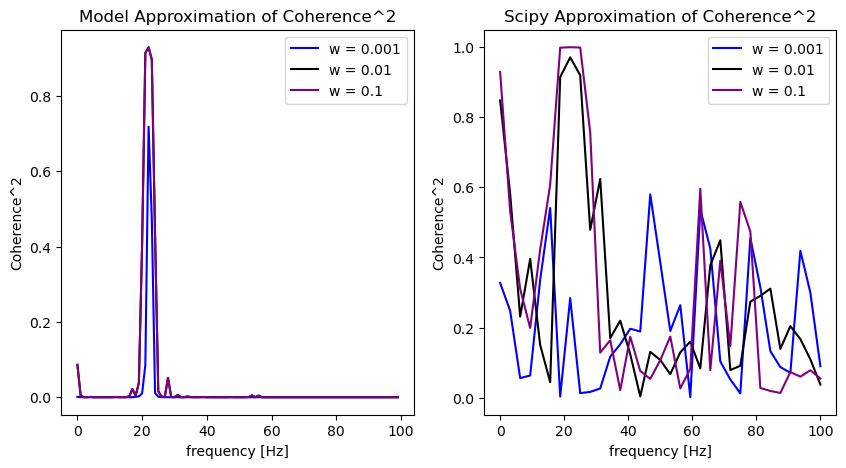

In [99]:
# Select parameters for coherence
SOS = 10
W1 = 0.001
W2 = 0.01
W3 = 0.1

f, coh2_1 = get_coherence2(TSTOP, SAMPLING_RATE, SOS, 21, W1, random_state)
f, coh2_2 = get_coherence2(TSTOP, SAMPLING_RATE, SOS, 21, W2, random_state)
f, coh2_3 = get_coherence2(TSTOP, SAMPLING_RATE, SOS, 21, W3, random_state)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W1, random_state)
f_scipy, coh2_1_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W2, random_state)
f_scipy, coh2_2_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W3, random_state)
f_scipy, coh2_3_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(f, coh2_1, label="w = 0.001", color="blue")
ax[0].plot(f, coh2_2, label="w = 0.01", color="black")
ax[0].plot(f, coh2_2, label="w = 0.1", color="purple")
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Coherence^2')
ax[0].legend()
ax[0].set_title('Model Approximation of Coherence^2')

ax[1].plot(f_scipy, coh2_1_scipy, label="w = 0.001", color="blue")
ax[1].plot(f_scipy, coh2_2_scipy, label="w = 0.01", color="black")
ax[1].plot(f_scipy, coh2_3_scipy, label="w = 0.1", color="purple")
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Coherence^2')
ax[1].legend()
ax[1].set_title('Scipy Approximation of Coherence^2')

plt.show()

Above, we see a beta peak in the coherence of both signals (around 20 Hz) with the higher weight signal displaying stronger coherence than the lower weight signal. 

For Figure D2, the connection weights remain constant at $w = 0.025$ but we vary SOS, from $SOS_1 = 10$ to $SOS_2 = 20$.

Scipy approximations can't be compared here since SOS isn't factored into the PSDs using scipy. 

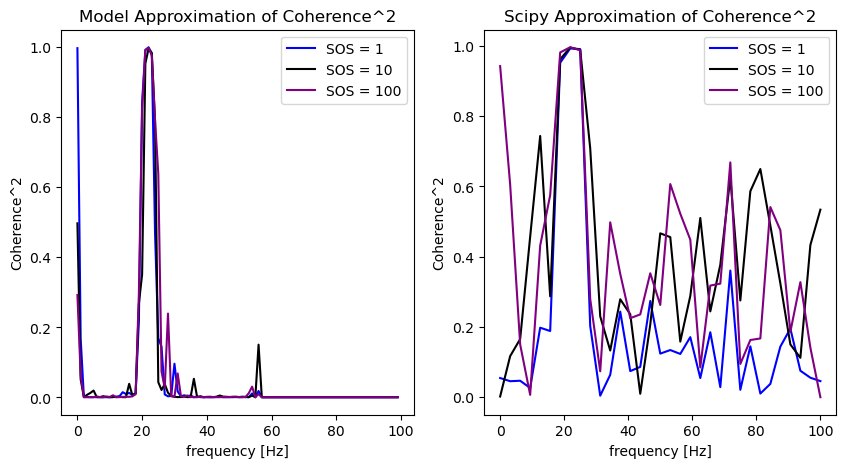

In [101]:
# Select parameters for coherence
SOS1 = 1
SOS2 = 10
SOS3 = 100
W = 0.025

f, coh2_1 = get_coherence2(TSTOP, SAMPLING_RATE, SOS1, 21, W, random_state)
f, coh2_2 = get_coherence2(TSTOP, SAMPLING_RATE, SOS2, 21, W, random_state)
f, coh2_3 = get_coherence2(TSTOP, SAMPLING_RATE, SOS3, 21, W, random_state)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS1, 21, W, random_state)
f_scipy, coh2_1_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS2, 21, W, random_state)
f_scipy, coh2_2_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS3, 21, W, random_state)
f_scipy, coh2_3_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(f, coh2_1, label="SOS = 1", color="blue")
ax[0].plot(f, coh2_2, label="SOS = 10", color="black")
ax[0].plot(f, coh2_3, label="SOS = 100", color="purple")
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Coherence^2')
ax[0].legend()
ax[0].set_title('Model Approximation of Coherence^2')

ax[1].plot(f_scipy, coh2_1_scipy, label="SOS = 1", color="blue")
ax[1].plot(f_scipy, coh2_2_scipy, label="SOS = 10", color="black")
ax[1].plot(f_scipy, coh2_3_scipy, label="SOS = 100", color="purple")
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Coherence^2')
ax[1].legend()
ax[1].set_title('Scipy Approximation of Coherence^2')

plt.show()

#### Figure 2E

The final figure compares the SSM model to experimental data, exhibiting a close fit between the two, especially around the beta peak. Since we don't have experimental data available, this figure simply demonstrates how another change in weights and sender oscillation strength (as specified in Vinck 2021) can change the coherence of the signal. Here, the SOS is unspecified, so is left at 10, and $w = 0.069$.

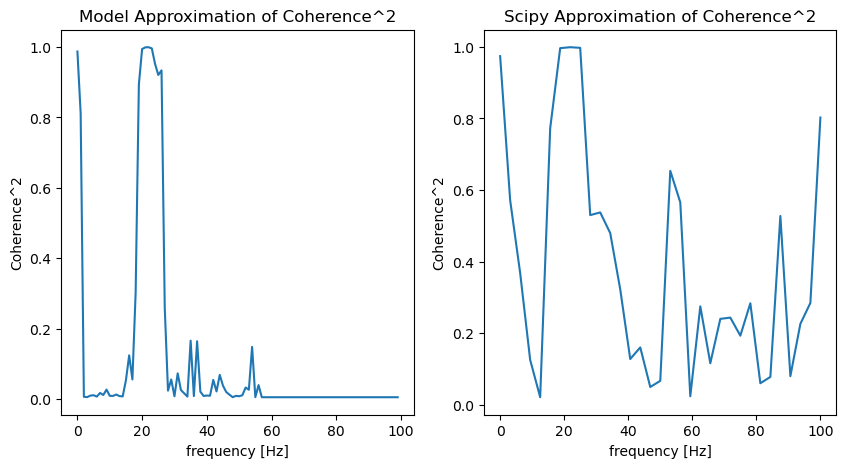

In [103]:
# Select parameters for coherence
SOS = 10
W = 0.069

f, coh2 = get_coherence2(TSTOP, SAMPLING_RATE, SOS, 20, W, random_state)

# Plot!
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(f, coh2)
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Coherence^2')
ax[0].set_title('Model Approximation of Coherence^2')

z1, z2, n1, n1_adjusted, alpha, freqs = generate_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state)
f_scipy, coh2_scipy = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)
ax[1].plot(f_scipy, coh2_scipy)
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Coherence^2')
ax[1].set_title('Scipy Approximation of Coherence^2')
plt.show()

# SSM with Source Projection Coherence

It is not likely the case that the sending region and receiving regions are fully coherent because (1) the sender has subpopulations of neurons that aren't fully coherent with each other and (2) the number of projecting neurons in the sender may be small. 

Vinck models inter-areal coherence with a linear dependence on source projection coherence. We model the sending signal the same way as in the SSM model without source projection coherence:

$z_1(t) = s_1(t) + \eta_1(t)$

But, instead of directly weighting the sent signal in the receiver, the sent signal is modelled as $s_1^*(t) + \epsilon_1(t)$ where $s_1^*(t)$ is the projected oscillatory signal into the receiver and $\epsilon_1(t)$ is the projected background signal into the receiver. So, the receiver region signal is given by:

$z_2(t + \tau) = \eta_2(t + \tau) + w (s_1^*(t) + \epsilon_1(t))$. 

We assume that $s_1(t)$ and $s_1^*(t)$ have the same power spectral densities and $\eta_1(t)$, $\eta_2(t)$, and $\epsilon_1(t)$ have the same power spectral densities. Altering the coherence between the projected sent signal and background noise models changes in source projection coherence. 

Here, the power and cross power spectral densities of the sender and receiver signals are given by

$Z_{11} = S_{11}(f) + H(f)$,

$Z_{22} = wS_{11}(f) + (1+w)H(f)$, and

$Z_{12} = w( C_{s,s}(f)S_{11}(f) + C_{\eta, \epsilon}(f)H(f))$

where $C_{s,s}$ is the coherence between $s_1(t)$ and $s_1^*(t)$ and $C_{\eta, \epsilon}$ is the coherence between $\eta_1(t)$ and $\epsilon_1(t)$.

The squared coherence formula remains the same as above, but simplifies to:

$C^2(f) = \frac{w^2(C_{ss}(f)\alpha(f) + C_{\eta, \epsilon}(f))^2}{(1 + \alpha(f))(1 + w(1 + \alpha(f))}$.

The source projection coherence is given by:

$C_{source, proj}(f) = C_{ss}(f) = C_{\eta, \epsilon}(f)$.

This model is not used in the simulations throughout. 


## Vinck 2021 Figure 3 Replication
Figure 3 examines the source projection coherence case of the model. 
According to Vinck, the sender signal is modelled as: 

$z_1(t) = s_1(t) + (\sqrt{1 - \gamma}) \eta_1(t) + \sqrt{\gamma} \epsilon(t)$

The receiver signal is modelled as:

$z_2(t + \tau) = \eta_2(t) + w(s_1(t - t_{delay}) + \eta_1(t - t_{delay}))$

We assume that $\gamma = 0.95$ for all simulations and the transmission delay $t_{delay} = 4$ ms. 

In line with Vinck's simulations, we assume that $s_t(t - t_{delay})$ is fully coherent with $s_1(t)$. We assume $\epsilon_1(t) = \eta_1(t - t_{delay})$ where $\eta_1(t - t_{delay})$ is a pink noise process "behind" $\eta_1(t)$ by 10 ms (up from Vinck's 4 ms time delay).

Assume $\alpha$ (SOS) is the ratio of noise processes in the sending to the receiving regions. 

Here, we assume that we take 10000 measurements, each 10 ms apart with the same AR(2) process modelling the sending region $s_1(t)$ oscillatory process as in the Figure 2 replication.

Note that we only cover population level dynamics, and as a result, only part of figure 3A and the entirety of figure 3D are included here. 

In [106]:
# Sender signal parameters 
SOS = 14             # Sender Oscillation Strength
W = 0.1               # connection weight between regions
TSTOP = 1
SAMPLING_FREQ = 200   # Sampling frequency (100/sec)
gamma = 0.95          # Kept constant for all simulations


def generate_SP_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma):
    # Generate oscillatory process and noise of sender. 
    s1 = generate_harmonic_AR2_process(tstop * sampling_rate, random_state, 20)
    n1 = generate_noise_process(tstop * sampling_rate, random_state)
    n2 = generate_noise_process(tstop * sampling_rate, random_state) # Intrinsic receiver noise
    n3 = generate_noise_process(tstop * sampling_rate, random_state) # Epsilon noise process in sender.

    # Offset noise (for epsilon in the sender signal and the receiver signal). Add a random gaussian value
    # to the beginning and take off the last value. 
    on1 = n1[:len(n1) - 1]
    on1 = np.insert(on1, 0, np.random.normal(size=1)) 

    # Ensuring the (average) ratio between sending and receiving noise processes equals SOS. 
    z1n = math.sqrt(1 - gamma) * n1 + math.sqrt(gamma) * n3
    z2n = n2 + w * on1 

    # FFT the sender's components and scale freq_SOS according to SOS
    z1n_fft = fft(z1n)
    z1s_fft = fft(z2n)
    freqs = fftfreq(tstop * sampling_rate, 1 / sampling_rate)

    # Get current SOS ratio at the freq_SOS. 
    freq_SOS_index = np.argmin(np.abs(freqs - freq_SOS))
   
    # Calculate current SOS, assuming it's the ratio of absolute valued and squared s1 to n1.
    current_SOS = np.square(np.abs(z1s_fft[freq_SOS_index])) / np.square(np.abs(z1n_fft[freq_SOS_index]))
    
    # Checking...
    old_power = np.square(np.abs(z1s_fft[freq_SOS_index]))

    # Multiplier to calculate new SOS 
    multiplier = SOS / current_SOS

    # Scaling noise at freq_SOS by multiplying by sqrt of multiplier
    z1n_fft[freq_SOS_index] = z1n_fft[freq_SOS_index] * np.sqrt(multiplier)
    
    # Taking the real part of the inverse fft of the adjusted n1_fft
    z1n_adjusted = ifft(z1n_fft).real
    alpha = np.abs(z1s_fft) ** 2 / np.abs(z1n_fft) ** 2

    # Checking...
    print(f"FFT({freq_SOS})^2 = {old_power} -> {np.real(z1n_fft[np.argmin(np.abs(freqs - freq_SOS))] ** 2)}")
    print(f"SOS = {current_SOS.real} -> {SOS}")

    # Total sender
    z1 = s1 + z1n_adjusted
    z2 = w * s1 + z2n
    
    return z1, z2, z1n_adjusted, z2n, s1, alpha, freqs


### Signal Check

FFT(21)^2 = 1.5920838504921864 -> -1.9119937486449046
SOS = 3.397949573228279 -> 14


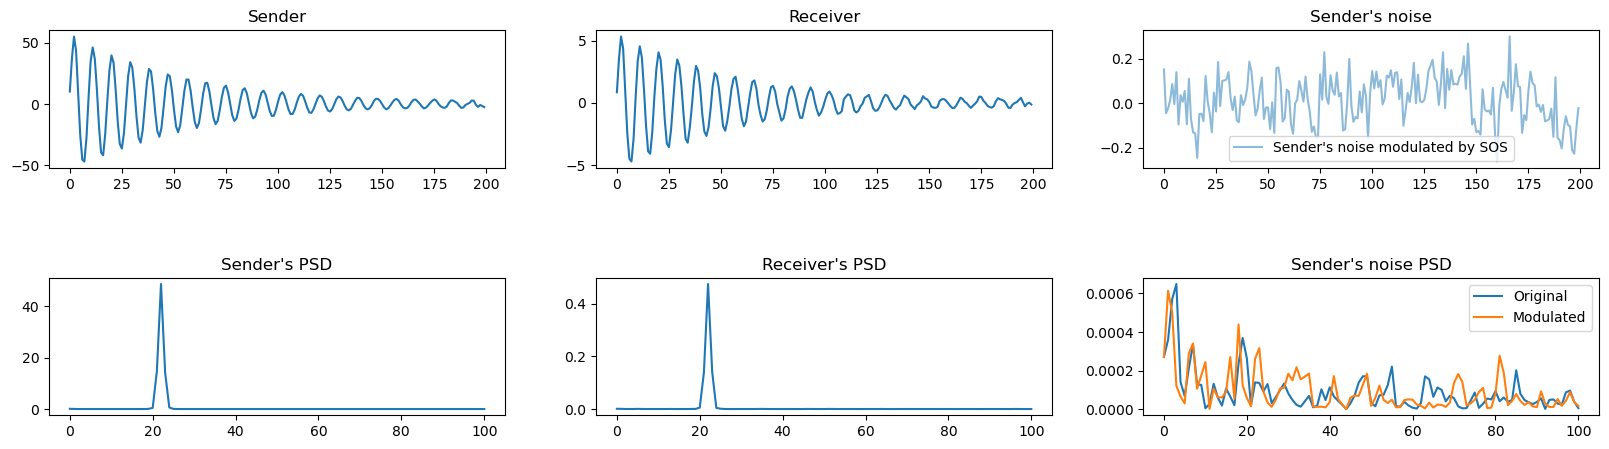

In [108]:
# Signal Check
fig, ax = plt.subplots(2, 3, figsize = (20, 5))

z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)

ax.flatten()[0].plot(z1)
ax.flatten()[0].set_title("Sender")

ax.flatten()[1].plot(z2)
ax.flatten()[1].set_title("Receiver")

ax.flatten()[2].plot(n1_adjusted, alpha = 0.5, label = "Sender's noise modulated by SOS")
ax.flatten()[2].legend()
ax.flatten()[2].set_title("Sender's noise")

f, psd = signal.welch(z1, fs = SAMPLING_RATE)
ax.flatten()[3].plot(f, psd)
ax.flatten()[3].set_title("Sender's PSD")

f, psd = signal.welch(z2, fs = SAMPLING_RATE)
ax.flatten()[4].plot(f, psd)
ax.flatten()[4].set_title("Receiver's PSD")

f, psd = signal.welch(n1, fs = SAMPLING_RATE)
ax.flatten()[5].plot(f, psd, label = "Original")
f, psd = signal.welch(n1_adjusted, fs = SAMPLING_RATE)
ax.flatten()[5].plot(f, psd, label = "Modulated")
ax.flatten()[5].set_title("Sender's noise PSD")
ax.flatten()[5].legend()

fig.subplots_adjust(hspace = 0.8)

#### Figure 3A

Consists of several figures at peak (optimal) coherence between frequencies. 

**Figure 3A(1)**

The leftmost figure compares power and frequency of the distribution. The plot indicates that the beta bump power should indicate the sender oscillation strength $\alpha(t)$ from the sending region. The plot is recreated below.  


FFT(21)^2 = 6.903588977263573 -> 0.18003767463785028
SOS = 11.828300200747758 -> 14
FFT(21)^2 = 0.12248426639180135 -> 106.91709069476146
SOS = 0.1204648538441353 -> 14


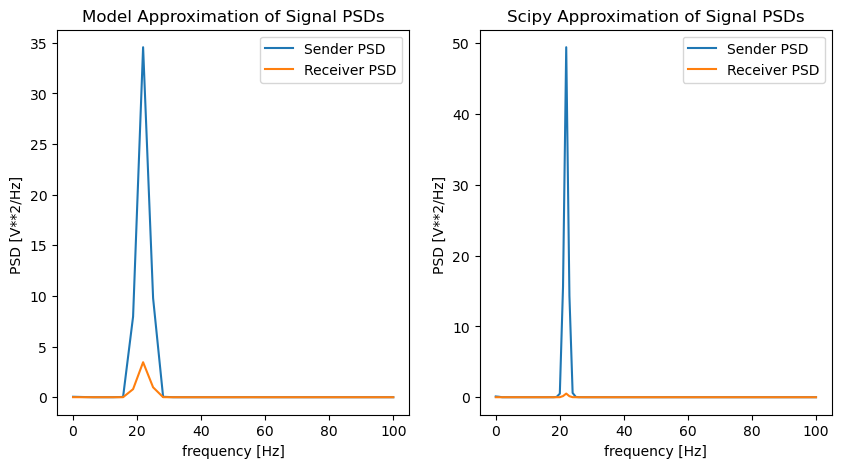

In [110]:
def generate_sender_receiver_SP_psd(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma):
    z1, z2, z1n_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma)
    f, psd_n1 = signal.welch(z1n_adjusted, fs = sampling_rate, nperseg=64)
    f, psd_s1 = signal.welch(z1 - z1n_adjusted, fs = sampling_rate, nperseg=64)

    interp_alpha = np.interp(x=f, xp=freqs, fp=alpha)
    #psd_z1 = (1 + interp_alpha) * psd_n1
    #psd_z2 = (1 + w*(1 + interp_alpha)) * psd_n1
    psd_z1 = psd_n1 + psd_s1
    psd_z2 = w * psd_s1 + (1 + w) * psd_n1
    return f, psd_z1, psd_z2


def generate_sender_receiver_scipy_SP_psd(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma):
    z1, z2, z1n_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma)
    
    f_z1, psd_z1 = signal.welch(z1, fs=sampling_rate)
    f_z2, psd_z2 = signal.welch(z2, fs=sampling_rate)
    return f_z1, psd_z1, psd_z2
    

f, psd_z1, psd_z2 = generate_sender_receiver_SP_psd(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)
fscipy, psdscipy_z1, psdscipy_z2 = generate_sender_receiver_scipy_SP_psd(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(f, psd_z1, label="Sender PSD")
axes[0].plot(f, psd_z2, label="Receiver PSD")
axes[0].set_xlabel('frequency [Hz]')
axes[0].set_ylabel('PSD [V**2/Hz] ')
axes[0].set_title('Model Approximation of Signal PSDs')
axes[0].legend()

axes[1].plot(fscipy, psdscipy_z1, label="Sender PSD")
axes[1].plot(fscipy, psdscipy_z2, label="Receiver PSD")
axes[1].set_xlabel('frequency [Hz]')
axes[1].set_ylabel('PSD [V**2/Hz] ')
axes[1].set_title('Scipy Approximation of Signal PSDs')
axes[1].legend()

plt.show()

**Figure 3A(2)**

The bottommost figure displays the relationship betweeen coherence (and by the proportionality relationship included in simulations for the SSM model without source projection coherence, Granger Causality) and frequency. Coherence and granger causality are proportional to SOS, interareal connectivity, and source-projection coherence.  

Here, we use the coherence relationship for the SSM model with source projection coherence in equation 20:

$C^2(f) = \frac{w^2(C_{ss}(f)\alpha(f) + C_{\eta, \epsilon}(f))^2}{(1 + \alpha(f))(1 + w(1 + \alpha(f))}$.

We assume $C_{ss}(f) = 1$ since the oscillator processes of the sender and receiver are considered equal. In line with Vinck's simulations, also assume $w = 0.1$ and $\alpha(f) = 14$. Then coherence is only dependent on the coherence between the projected and received broadband processes and some of the constants identified.  

In [112]:
def get_scipy_SP_coh(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma):
    # Uses scipy to get psd z1 and psd z2, and cross psd, then use coherence equation to get coherence. 
    z1, z2, n1, n2, s1, alpha, freqs = generate_SP_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma)
    
    f, Z11 = signal.welch(z1, fs=sampling_freq, nperseg=64)
    f, Z22 = signal.welch(z2, fs=sampling_freq, nperseg=64)
    f, Z12 = signal.csd(z1, z2, fs=sampling_freq, nperseg=64)
    
    psd_coh2 = np.abs(Z12)**2 / (Z11 * Z22)
    return f, psd_coh2


def get_SP_coh(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma):
    z1, z2, n1, n2, s1, alpha, freqs = generate_SP_sender_receiver(tstop, sampling_rate, SOS, freq_SOS, w, random_state, gamma)

    # Using scipy to get C_osc and C_noise
    f, C_noise = signal.coherence(n1, n2, fs=sampling_freq, nperseg=64)
    f, C_osc = signal.coherence(s1, np.multiply(s1, w), fs=sampling_freq, nperseg=64)

    # Approximating coherence based on formula 20
    interp_alpha = np.interp(x=f, xp=freqs, fp=alpha)
    form_coh2 = (w**2 * (C_osc * interp_alpha + C_noise)**2) / ((1 + interp_alpha)*(1 + w*(1 + interp_alpha)))
    return f, form_coh2



# Approximating coherence with several methods
z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)

# Scipy coherence function method
f, coh2_scipy = signal.coherence(z1, z2, fs=sampling_freq, nperseg=64)

# Scipy PSDs method
f, coh2_scipy_psds = get_scipy_SP_coh(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)

# Using the model approximation in equation 20. 
f, coh2 = get_SP_coh(TSTOP, SAMPLING_RATE, SOS, 21, W, random_state, gamma)

# Plot!
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,2))
ax[0].plot(f, coh2_scipy_psds, label="Scipy PSDs")
ax[0].plot(f, coh2_scipy, label="Scipy Coherence")
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Coherence^2')
ax[0].legend()
ax[0].set_title('Scipy Approximation of Coherence^2')

ax[1].plot(f, coh2)
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Coherence^2')
ax[1].set_title('Model (Eq. 20) Approximation of Coherence^2')



FFT(21)^2 = 0.6424537013471345 -> -29.830663424043195
SOS = 0.23340433400208518 -> 14


NameError: name 'sampling_freq' is not defined

#### Figure 3D

Examines how increases in the weight between sender and receiver regions and the SOS (ratio between sender oscillatory process and noise) alters the coherence betweeen the sending and receiving regions. We employ the scipy approximation of squared coherence here to compare between the different weights and SOS values. 

In the first simulation, $SOS = 10$, while two values of the population weights are compared: $w_1 = 0.025$ and $w_2 = 0.036$. 

FFT(21)^2 = 4.086049760540109 -> 11.827232320205427
SOS = 1.7357556837364263 -> 10
FFT(21)^2 = 0.9093809501530509 -> 5.551926416510298
SOS = 1.1071896085494504 -> 10
FFT(21)^2 = 3.300497434468151 -> -66.8248826738779
SOS = 0.6587535487018346 -> 10


Text(0.5, 1.0, 'Weight Comparison for Squared Coherence')

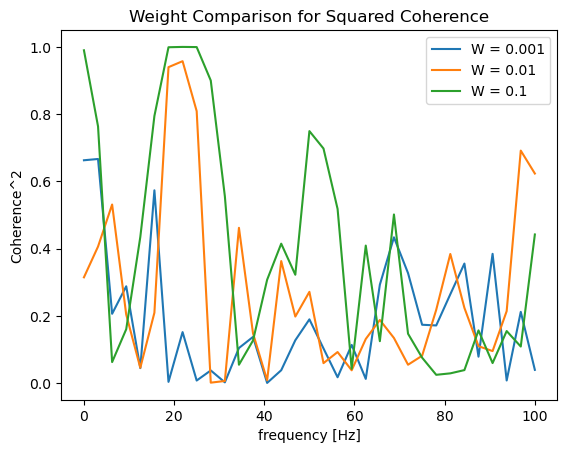

In [117]:
W1 = 0.001
W2 = 0.01
W3 = 0.1
SOS = 10

# Approximating coherence using scipy coherence function
z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W1, random_state, gamma)
f, coh2_1 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W2, random_state, gamma)
f, coh2_2 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS, 21, W3, random_state, gamma)
f, coh2_3 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

# Plot!
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(f, coh2_1, label="W = 0.001")
ax.plot(f, coh2_2, label="W = 0.01")
ax.plot(f, coh2_3, label="W = 0.1")
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Coherence^2')
ax.legend()
ax.set_title('Weight Comparison for Squared Coherence')

In the simulation comparing different SOS values, we set $w = 0.025$ and vary the SOS from $SOS = 10$ to $SOS = 20$. 

FFT(20)^2 = 2.6158746036901013 -> 0.03769525783631807
SOS = 7.358937078357871 -> 1
FFT(20)^2 = 6.26199585960187 -> -0.031272140225455734
SOS = 38.23812442812487 -> 10
FFT(20)^2 = 0.9260809045706114 -> 60.84583588618693
SOS = 1.180493544229963 -> 100


Text(0.5, 1.0, 'SOS Comparison for Squared Coherence')

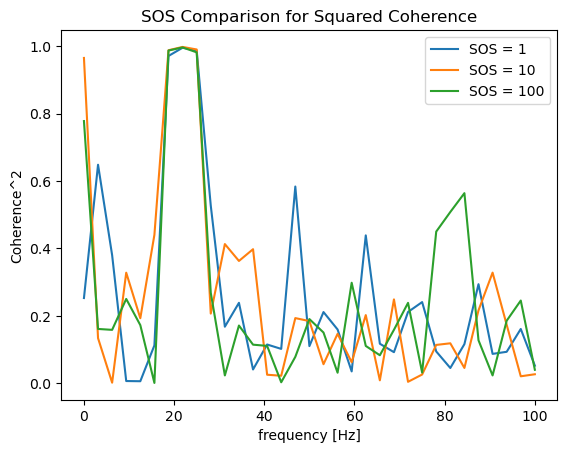

In [121]:
W = 0.025
SOS1 = 1
SOS2 = 10
SOS3 = 100

# Approximating coherence using scipy coherence function
z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS1, 20, W, random_state, gamma)
f, coh2_1 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS2, 20, W, random_state, gamma)
f, coh2_2 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

z1, z2, n1_adjusted, z2n, s1, alpha, freqs = generate_SP_sender_receiver(TSTOP, SAMPLING_RATE, SOS3, 20, W, random_state, gamma)
f, coh2_3 = signal.coherence(z1, z2, fs=SAMPLING_RATE, nperseg=64)

# Plot!
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(f, coh2_1, label="SOS = 1")
ax.plot(f, coh2_2, label="SOS = 10")
ax.plot(f, coh2_3, label="SOS = 100")
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Coherence^2')
ax.legend()
ax.set_title('SOS Comparison for Squared Coherence')